In [1]:
import sys
sys.path.insert(0, "..")

from sf_runoff import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from nested_CV import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from test import evaluate_prediction, plot_prediction, plot_anomalies
from test import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from classic_CV_predict import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns

nb_name=''


In [4]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [5]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'
daily_input = pd.read_csv(path+nb_name[:-13]+'.csv', index_col=0, parse_dates=True)

In [7]:
nb_name[:-13]

'ADO_DSC_CH03_0075'

In [8]:
t_unit=10

#define the possible parameters value (where Gridsearch is applied)


C_range=np.logspace(-1.5, 0.5, 10)
epsilon_range=np.logspace(-2.2, -0.2, 4)
#n_range = [17, 50, 200]
components_range = [5*4*36]
#do not enlarge t_range for now
t_range=[36]
t_length=t_range[0]
n_splits=4
test_size=730

Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits

ADO_DSC_CH03_0075_new_DS.ipynb
C=0.40842386526745217
eps=0.13593563908785247


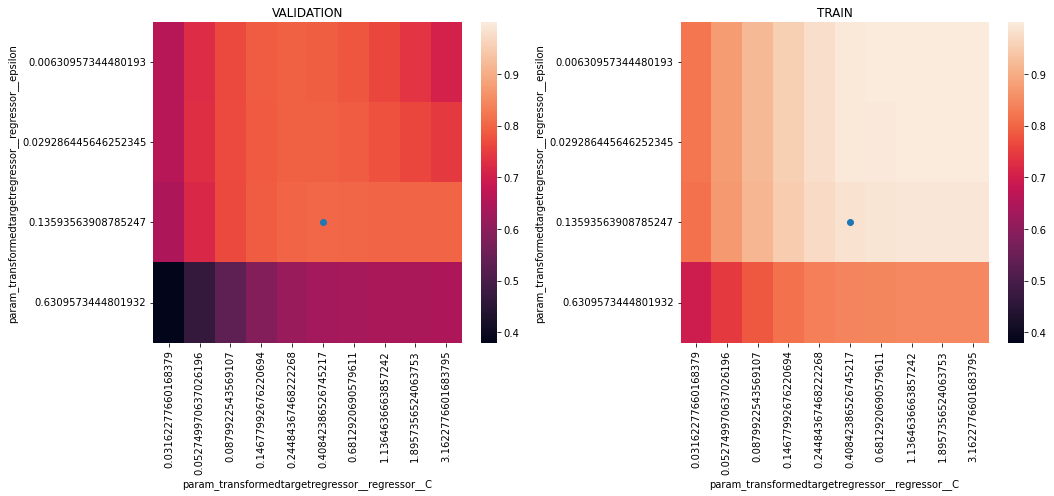

In [9]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(nb_name)
print(f'C={C}')
print(f'eps={eps}')

In [10]:
radius_for_ensemble = 1
predictions = nested_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

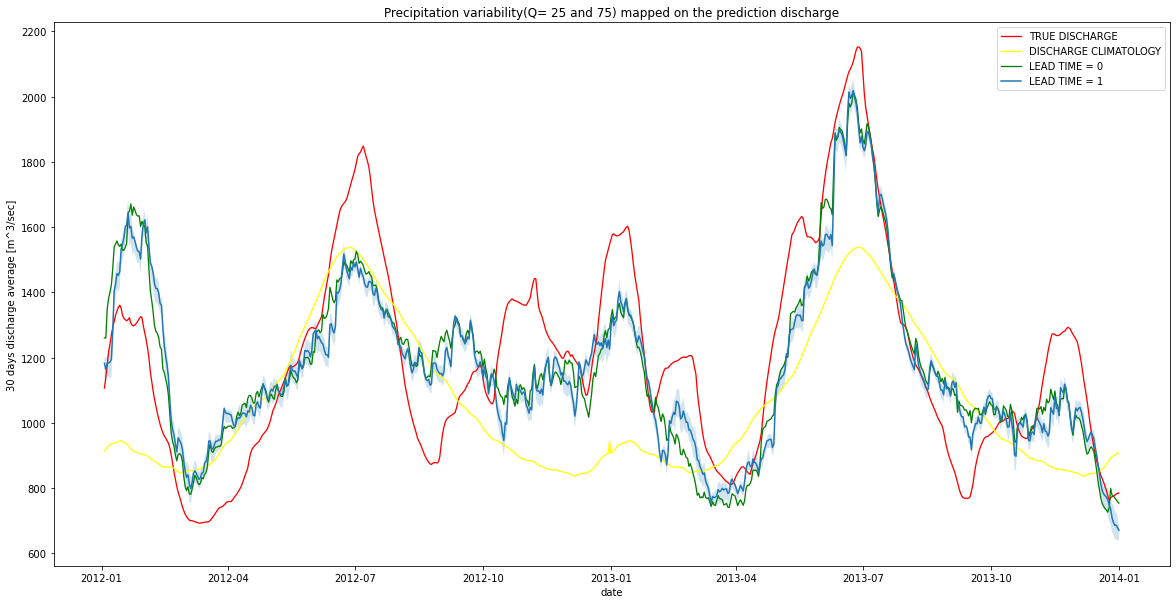

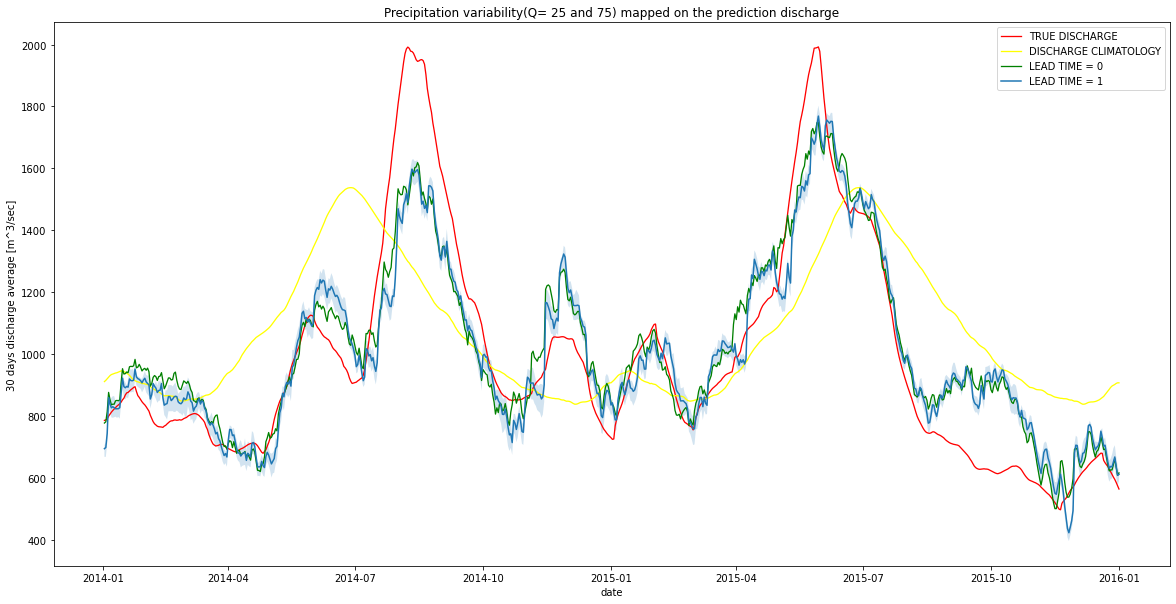

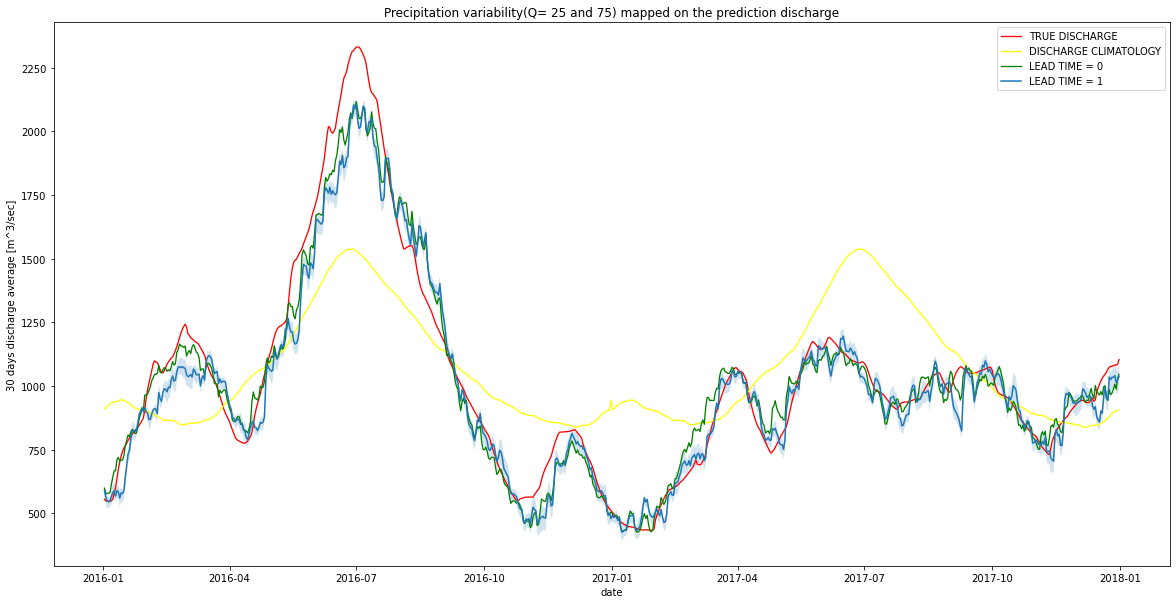

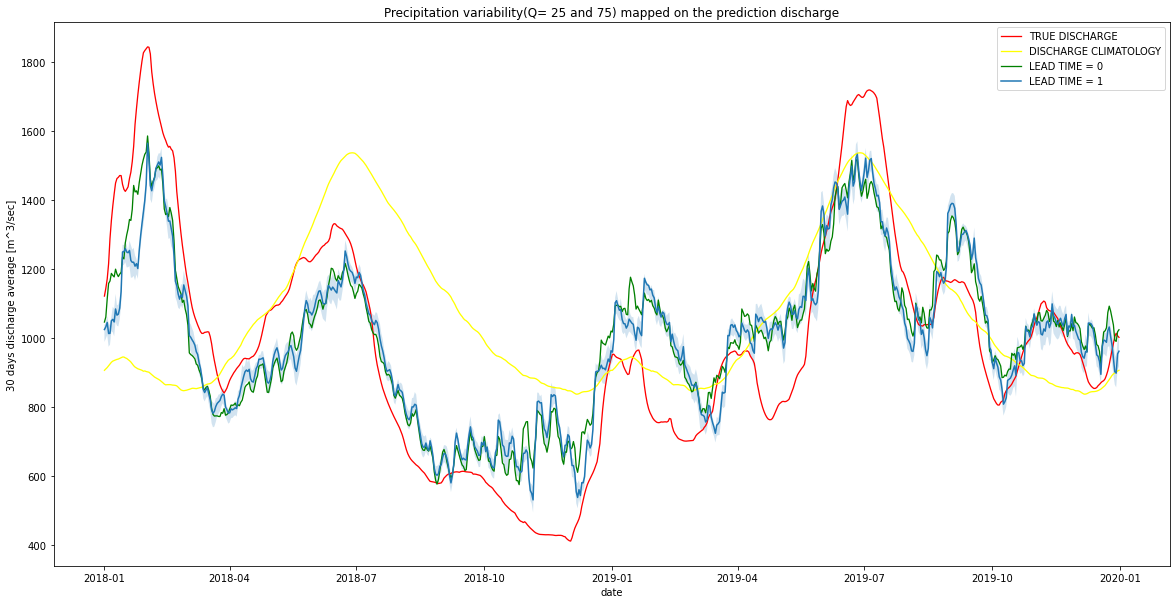

In [11]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions)


measured runoff             1.000000
runoff climatology          0.316451
runoff_clim_25              0.033739
runoff_clim_75              0.080071
model output                0.838855
output 1 month lead time    0.818649
output 2 month lead time    0.723636
output 3 month lead time    0.555670
output 4 month lead time    0.414971
output 5 month lead time    0.312024
dtype: float64

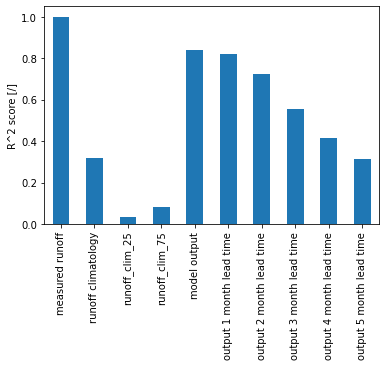

In [12]:
evaluate_prediction(predictions)

measured runoff             1.000000
runoff climatology          0.316451
runoff_clim_25              0.033739
runoff_clim_75              0.080071
model output                0.838855
output 1 month lead time    0.818649
output 2 month lead time    0.723636
output 3 month lead time    0.555670
output 4 month lead time    0.414971
output 5 month lead time    0.312024
dtype: float64

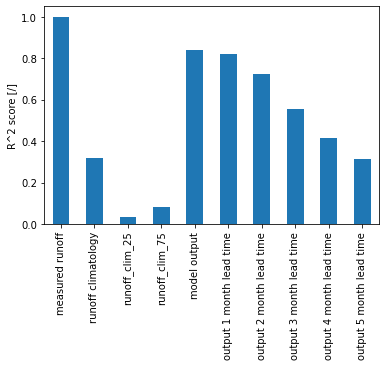

In [13]:
#previous result
evaluate_prediction(predictions)

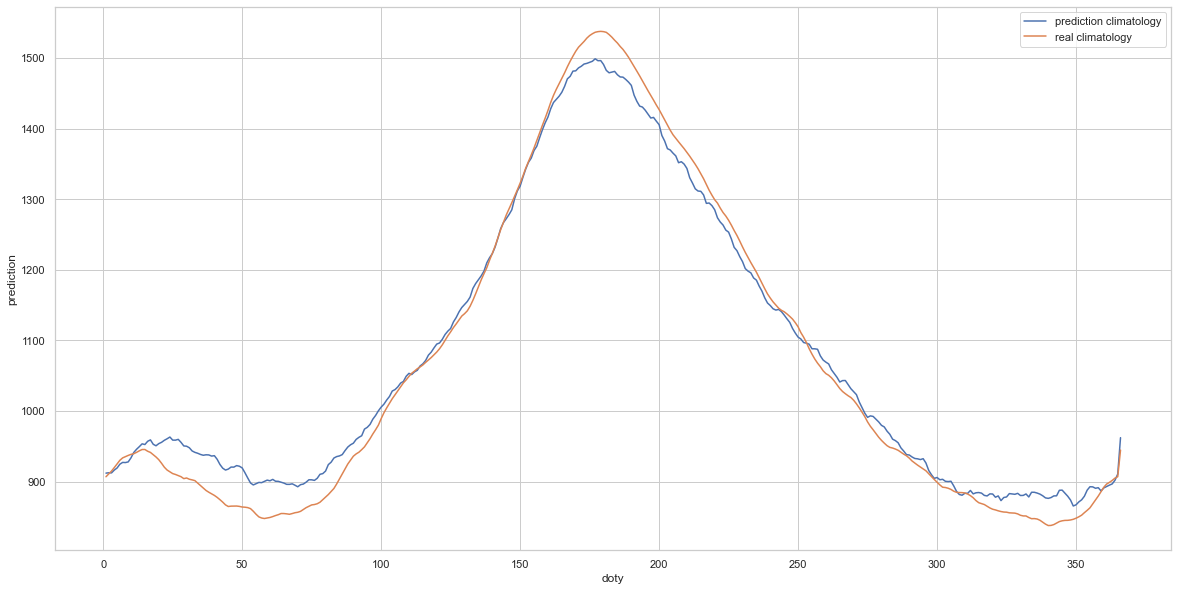

In [14]:
predictions_for_clim = classic_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits)
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index

sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

In [27]:
df=((predictions_for_clim))

In [37]:
from db_insert import insert
insert(nb_name[-7],predictions_for_clim)

In [42]:
nb_name[:-6]

'ADO_DSC_CH03_0075'

In [43]:
insert(nb_name[:-6],predictions_for_clim)

In [15]:
## model savior

from sklearn.svm import SVR, LinearSVR
from sf_runoff import create_it_matrix
from joblib import dump, load

it_matrix=create_it_matrix(daily_input,t_length,t_unit).astype('float32')

X = it_matrix.drop(columns='Q')
y = it_matrix['Q']
svr_estimator = SVR(kernel='rbf', gamma='scale', cache_size=15000,C=C,epsilon=eps)

svr_estimator = make_pipeline(StandardScaler(),
                              TransformedTargetRegressor(regressor=svr_estimator, transformer=StandardScaler()))

svr_estimator.fit(X, y)

path='models/'+nb_name[:-6]+'.joblib'

dump(svr_estimator, path)

['models/ADO_DSC_CH03_0075_new_DS.joblib']